# CS101: verified quantum information scrambling

This is based on work in Landsman, Kevin A., et al. "Verified quantum information scrambling." _Nature_ 567.7746 (2019): 61-65. We replicate the results given on ion-trap qubits using IBM Q superconducting hardware, which allows us to extend the circuit design to a larger number of qubits. We construct a circuit based on Figure 8 of the paper.

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ

In [3]:
backend = BasicAer.get_backend('qasm_simulator')

First, let's code the components of the circuit that we'll need to run. To extend to more qubits, we just add two-qubit gates and single-qubit rotations.

In [89]:
def initialize(qc, statenum):
    """
    Prepare an eigenstate of the Pauli X, Y, or Z operator.
    """
    # statenum == 0, do nothing (|0>)
    
    if statenum == 1: #|1>
        qc.x(0)
    elif statenum == 2: #|+>
        qc.h(0)
    elif statenum == 3: #|->
        qc.x(0)
        qc.h(0)
    elif statenum == 4: # y eigenstate
        qc.y(0)
        qc.h(0)
        qc.s(0)
    elif statenum == 5: # y eigenstate
        qc.x(0)
        qc.y(0)
        qc.h(0)
        qc.s(0)
        
def epr(qc, a, b):
    """
    Create an EPR pair between qubits at a and b.
    """
    qc.h(a)
    qc.cx(a, b)

def eprs(qc):
    """
    Create the EPR pairs necessary for the teleporation protocol, i.e.
    on the last two qubits and on pairs of qubits above (excluding the first qubit).
    """
    n = len(qc.qubits)
    epr(qc, n-2, n-1)
    for i in range((n-3)//2):
        epr(qc, i+1, n-3-i)

    
def random(qc, qubits, a, params=[], layers=1, conj=False, orig=True):
    """
    Model the black hole as a "random" unitary parameterized by `a` (scrambling parameter).
    Setting orig=True replicates Figure 8 of the paper, while orig=False uses CZ and RX
    gates instead of XX and CZ gates, since this is more natural for the IBM gate basis.
    """
    layers *= 2
    n = len(qubits)
    if len(params) == 0:
        params = np.ones(n*layers) * np.pi/2
    
    pind = 0
    for i in range(layers):
        # two-qubit gates
        twos = n
        if n == 2:
            twos = n - 1
        for j in range(twos):
            t = np.pi/2
            if conj:
                t *= -1
            j2 = (j + 1) % n
            if orig:
                qc.rxx(t, qubits[j], qubits[j2])
            else:
                qc.cz(qubits[j], qubits[j2])
        # single-qubit rotations
        for j in range(n):
            t = params[pind]
            if conj:
                t *= -1
            if i % 2 == 1:
                t *= -1
            if orig:
                qc.rz(a*t, qubits[j])
            else:
                qc.rx(a*t, qubits[j])
            pind += 1
    return params

def end(qc, statenum):
    """
    Undo the state preparation of |psi>, so we can measure how similar the teleported
    state is to the initial state.
    """
    # statenum == 0, do nothing (|0>)
    i = len(qc.qubits) - 1
    if statenum == 1: #|1>
        qc.x(i)
    elif statenum == 2: #|+>
        qc.h(i)
    elif statenum == 3: #|->
        qc.h(i)
        qc.x(i)
    elif statenum == 4: # y eigenstate
        qc.sdg(i)
        qc.h(i)
        qc.y(i)
    elif statenum == 5: # y eigenstate
        qc.sdg(i)
        qc.h(i)
        qc.y(i)
        qc.x(i)
        
def bell_measure_prep(qc, crx, crz):
    """
    Add the gates needed for a Bell measurement.
    """
    n = len(qc.qubits)
    q1 = n//2 - 1
    q2 = n//2
    qc.cx(q1, q2)
    qc.h(q1)
    
def measure(qc, crx, crz, cr):
    """
    Measure the Hawking-radiated qubit, Bob's complement, and the teleported qubit.
    """
    n = len(qc.qubits)
    q1 = n//2 - 1
    q2 = n//2
    
    qc.barrier()
    qc.measure(q1, crz)
    qc.measure(q2, crx)
    
    qc.measure(n - 1, cr)

Now we can prepare the actual code for running this, starting with simulation. As in the original paper, we post-select on the Bell measurement giving 00. Note that this gives different results from running CX and CZ gates to undo the one-time pad encoding as is typical in a teleportation protocol; to properly run the protocol without post-selection, we would need Grover's search algorithm like in Figure 4 of the paper. However, we want to keep the circuit as shallow as possible since we'll be running on hardware, so we choose to stick to post-selection.

In [230]:
def experiment(n, s, alpha, layers=1, params=None, shots=1000, display=False, orig=True):
    """
    Simulate a circuit for a given set of parameters and return both it and the teleportation fidelity.
    Returns circuit, F, P, N
    """
    qr = QuantumRegister(n)
    crx = ClassicalRegister(1, name='crb1')
    crz = ClassicalRegister(1, name='crb2')
    cr = ClassicalRegister(1, name='cr')
    circ = QuantumCircuit(qr, crx, crz, cr)
    initialize(circ, s)
    eprs(circ)
    if params is None:
        params = random(circ, np.arange(0, n//2), alpha, layers=layers, orig=orig)
    else:
        random(circ, np.arange(0, n//2), alpha, layers=layers, params=params, orig=orig)
    random(circ, np.arange(n//2, 2*(n//2)), alpha, layers=layers, params=params, conj=True, orig=orig)
    bell_measure_prep(circ, crx, crz)
    end(circ, s)
    measure(circ, crx, crz, cr)
    if display:
        print(circ)
    job = execute(circ, backend, shots=shots)
    counts = job.result().get_counts()
    if '1 0 0' not in counts:
        counts['1 0 0'] = 0
    F = counts['0 0 0']/(counts['0 0 0'] + counts['1 0 0'])
    P = (counts['0 0 0'] + counts['1 0 0'])/sum(counts.values())
    N = 2*(3*F*P - P)
    return circ, F, P, N

def simulate(n, orig):
    """
    Run through different values of the scrambling parameter and assemble the simulation results.
    """
    layers = 1
    alphas = np.linspace(0, 1, 10)
    y = []
    params = np.ones(n*layers) * np.pi/2
    circuits = []
    for a in alphas:
        avg = np.zeros(3)
        for s in range(6):
            c, F, P, N = experiment(n, s, a, layers=layers, params=params, orig=orig)
            avg += np.array([F, P, N])
            circuits.append(c)
        avg /= 6
        y.append(avg)
    return y, circuits

Let's check if this looks like the original paper. We show both the original circuit with XX gates, as well as our more IBM-friendly circuit with CZ gates.

In [198]:
c, _ = experiment(7, 1, 0.5, layers=1, params=np.ones(7) * np.pi/2, orig=True)
print(c)
c, _ = experiment(7, 1, 0.5, layers=1, params=np.ones(7) * np.pi/2, orig=False)
print(c)

            ┌───┐     ┌────────────┐                ┌────────────┐»
q1385_0: |0>┤ X ├─────┤0           ├────────────────┤1           ├»
            ├───┤     │  Rxx(pi/2) │ ┌────────────┐ │            │»
q1385_1: |0>┤ H ├──■──┤1           ├─┤0           ├─┤  Rxx(pi/2) ├»
            ├───┤  │  └────────────┘ │  Rxx(pi/2) │ │            │»
q1385_2: |0>┤ H ├──┼────────■────────┤1           ├─┤0           ├»
            └───┘  │      ┌─┴─┐     ┌┴────────────┤ └────────────┘»
q1385_3: |0>───────┼──────┤ X ├─────┤0            ├───────────────»
                 ┌─┴─┐    └───┘     │  Rxx(-pi/2) │┌─────────────┐»
q1385_4: |0>─────┤ X ├──────────────┤1            ├┤0            ├»
            ┌───┐└───┘              └─────────────┘│  Rxx(-pi/2) │»
q1385_5: |0>┤ H ├──■───────────────────────────────┤1            ├»
            └───┘┌─┴─┐    ┌───┐                    └─────────────┘»
q1385_6: |0>─────┤ X ├────┤ X ├───────────────────────────────────»
                 └───┘    └───┘                 

Great! Now we can run the simulations and plot the output. We're looking to see something like in Figure 2b of the original paper.

In [231]:
all_circuits = []
all_y = []
for n in range(5, 17, 2):
    for i in range(2):
        y, circuits = simulate(n, bool(i))
        all_circuits.append(circuits)
        all_y.append(y)
all_y = np.array(all_y)

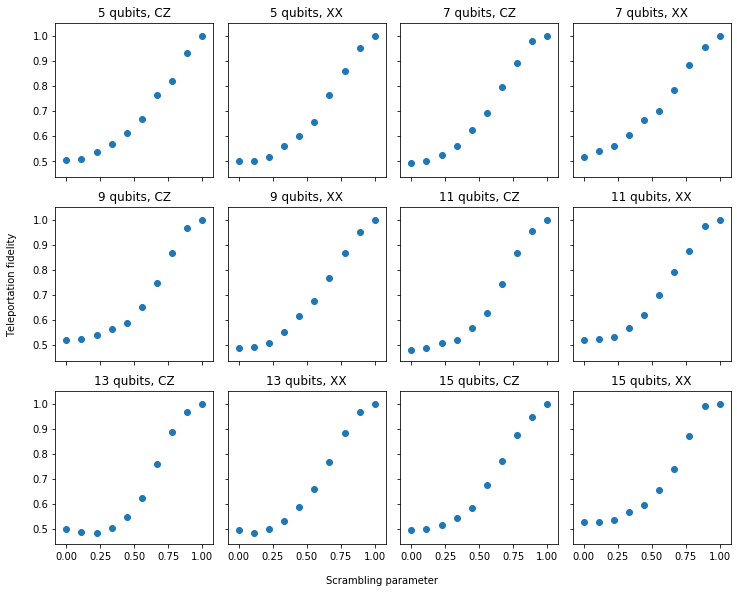

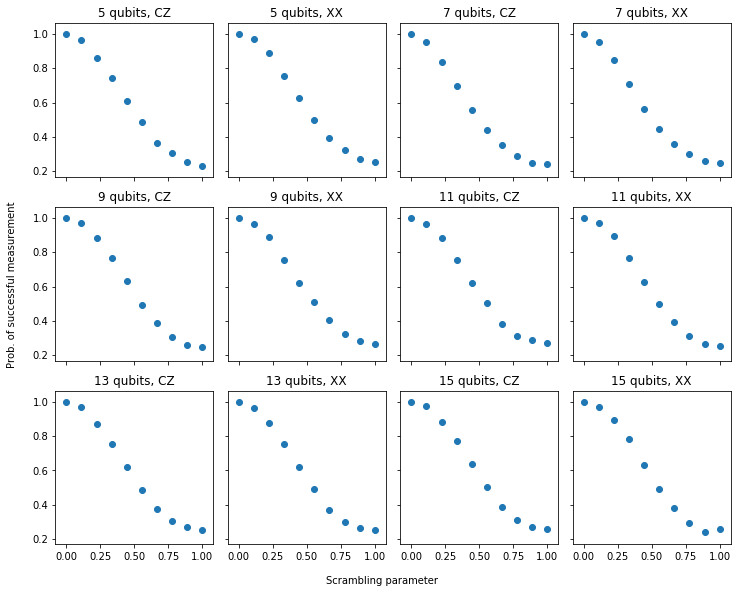

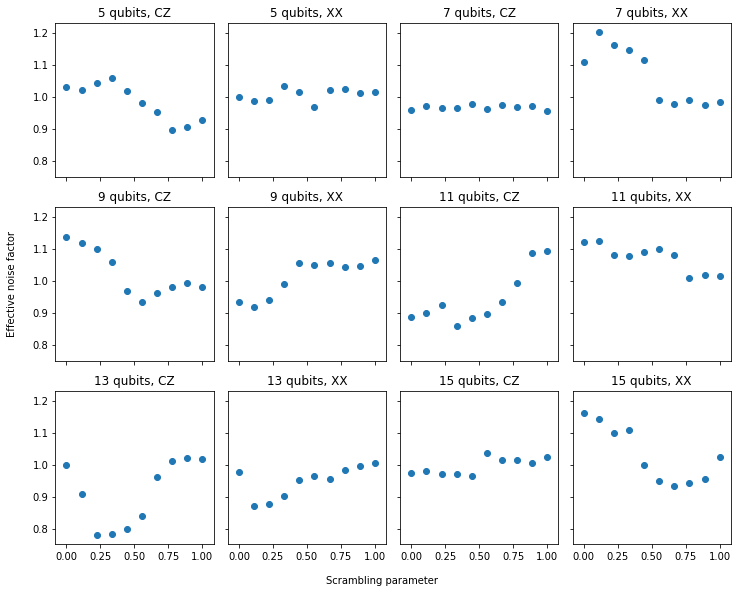

In [236]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_sim(k):
    fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(10, 8))
    cind = 0
    names = ['Teleportation fidelity', 'Prob. of successful measurement', 'Effective noise factor']
    for n in range(5, 17, 2):
        for i in range(2):
            x1 = cind // 4
            x2 = cind % 4
            y = all_y[cind]
            axs[x1, x2].scatter(alphas, y[:, k])
            label = 'XX'
            if i == 0:
                label = 'CZ'
            axs[x1, x2].set_title(str(n) + ' qubits, ' + label)
            cind += 1
    fig.text(0.5, -0.02, 'Scrambling parameter', ha='center')
    fig.text(-0.02, 0.5, names[k], va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

for k in range(3):
    plot_sim(k)

Looks good, the extension to more qubits worked relatively well! The higher qubits are somewhat more unstable on $\mathcal{N}$, but that's to be expected: they're more sensitive to fewer shots. They stay within 0.8 to 1.2, in sharp contrast to the rotation mismatch in the paper that dips to 0.

Let's move to running on actual hardware. The computers are quite noisy, so we'll try running on all of them and see how they turn out. We try not optimizing the circuit compilation so that the circuits all have roughly the same depth; otherwise, fidelities might change in a different way with respect to the scrambling parameter.

In [38]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

In [226]:
def run(n, i_choices=[0, 1], j_choices=[0, 1]):
    """
    Run an n-qubit circuit on IBM device(s) for different circuits (CZ or XX)
    and with different compiler optimization levels at the max # of shots.
    """
    all_outs = []
    for i in i_choices: # CZ, XX
        for j in j_choices: # optimization level
            if n <= 5:
                backends = ['ibmq_16_melbourne', 'ibmq_burlington', 'ibmq_essex', 'ibmq_london', 'ibmq_ourense', 'ibmq_rome', 'ibmq_vigo', 'ibmq_5_yorktown']
            else:
                backends = ['ibmq_16_melbourne']
            outs = []
            for b in backends:
                qbackend = provider.get_backend(b)
                out = execute(all_circuits[(n-5) + i], qbackend, shots=8192, optimization_level=round(3*j))
                outs.append(out)
            all_outs.append(outs)
    return all_outs

In [240]:
def process(n, all_outs, i_choices=[0, 1], j_choices=[0, 1]):
    """
    Process the results of the IBM Q jobs, calculating the teleportation fidelity.
    """
    oind = 0
    all_ys = []
    for i in i_choices: # CZ, XX
        for j in j_choices: # optimization level
            if n <= 5:
                backends = ['ibmq_16_melbourne', 'ibmq_burlington', 'ibmq_essex', 'ibmq_london', 'ibmq_ourense', 'ibmq_rome', 'ibmq_vigo', 'ibmq_5_yorktown']
            else:
                backends = ['ibmq_16_melbourne']
            backend_ys = []
            for k in range(len(backends)):
                b = backends[k]
                res = all_outs[oind][k].result()
                l = 0
                oy = []
                for a in alphas:
                    avg = np.zeros(3)
                    for s in range(6):
                        counts = res.get_counts(l)
                        F = counts['0 0 0']/(counts['0 0 0'] + counts['1 0 0'])
                        P = (counts['0 0 0'] + counts['1 0 0'])/sum(counts.values())
                        N = 2*(3*F*P - P)
                        avg += np.array([F, P, N])
                        l += 1
                    avg /= 6
                    oy.append(avg)
                backend_ys.append(oy)
            all_ys.append(backend_ys)
            oind += 1
    return np.array(all_ys)

In [241]:
n = 5
outs_5 = run(n)
ys_5 = process(n, outs_5)

Now we're ready to plot. Let's plot all the computers and see how they look.

In [278]:
def plot_5(orig, opt, all_ys, m):
    i = int(orig)
    cind = i
    j = opt
    ys = all_ys[2*i + j]
    backends = ['ibmq_16_melbourne', 'ibmq_burlington', 'ibmq_essex', 'ibmq_london', 'ibmq_ourense', 'ibmq_rome', 'ibmq_vigo', 'ibmq_5_yorktown']    
    names = ['Teleportation fidelity', 'Prob. of successful measurement', 'Effective noise factor']
    metrics = ['F', 'P', 'N']
    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 6))
    for i in range(len(backends)):
        x1 = i // 4
        x2 = i % 4
        axs[x1, x2].scatter(alphas, ys[i][:, m], label='Hardware')
        axs[x1, x2].scatter(alphas, all_y[cind][:, m], label='Simulation')
        axs[x1, x2].set_title(backends[i])
#         axs[x1, x2].set_ylim(0.5, 1)
        if i == 0:
            axs[x1, x2].legend(loc='upper left')
    txt1 = fig.text(0.5, -0.02, 'Scrambling parameter', ha='center')
    txt2 = fig.text(-0.02, 0.5, names[m], va='center', rotation='vertical')
    label = 'CZ'
    if orig:
        label = 'XX'
    level = 'full'
    if opt == 0:
        level = 'no'
    main = '5 qubits, ' + label + ' circuit, ' + level + ' compiler optimization'
    txt3 = fig.text(0.5, 1.0, main, ha='center', fontsize=16)
    plt.tight_layout()
    plt.savefig('out/5q_' + label + '_' + level + '_' + metrics[m] + '.pdf', bbox_extra_artists=(txt1, txt2, txt3), bbox_inches='tight')

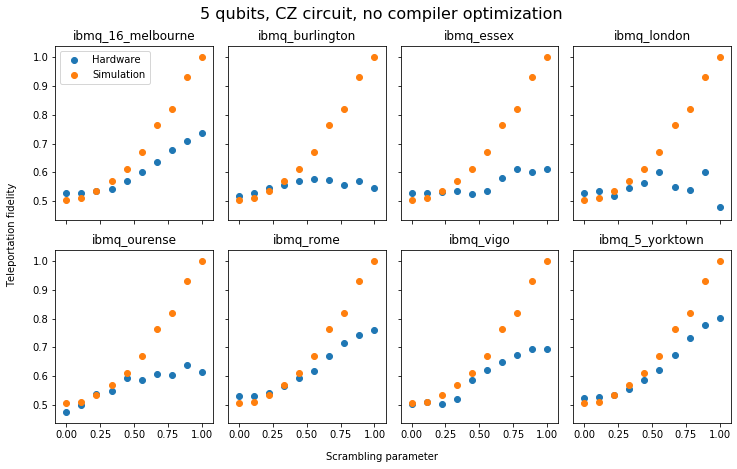

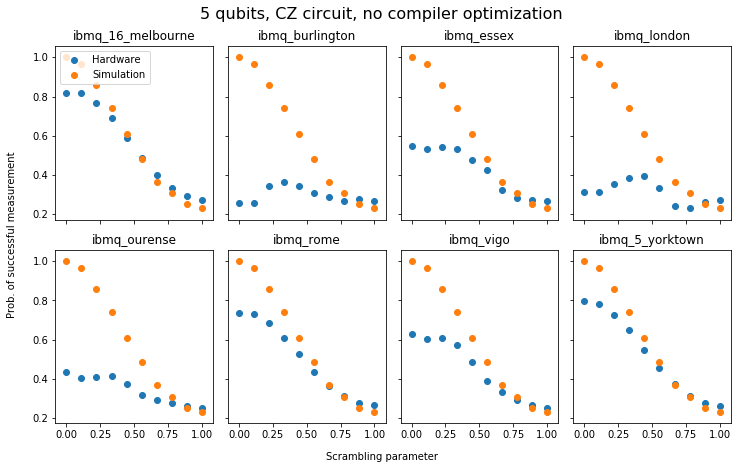

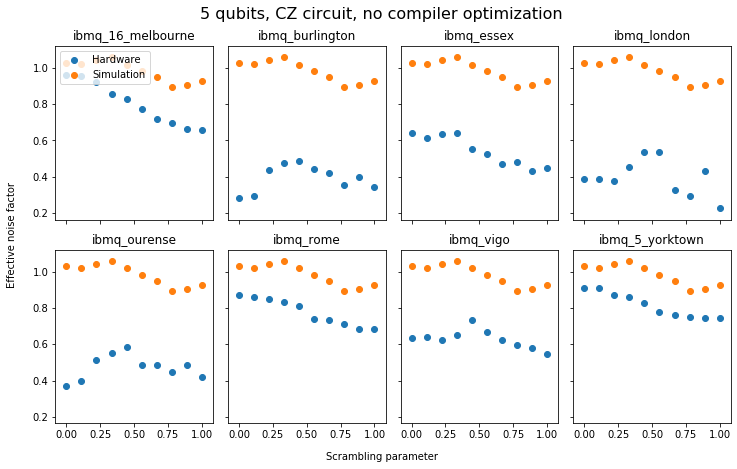

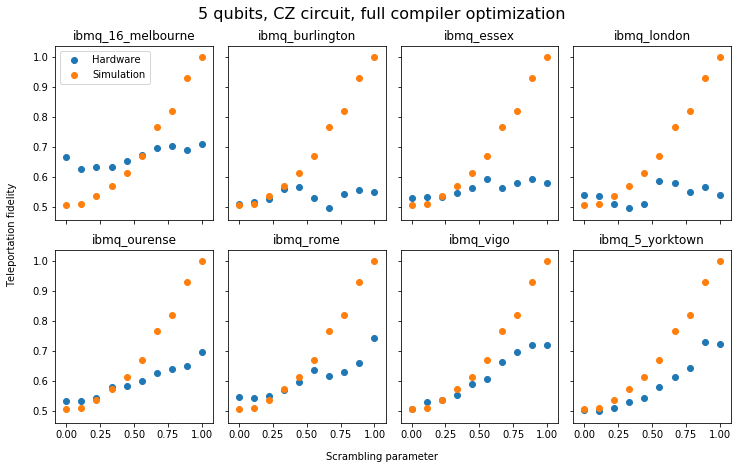

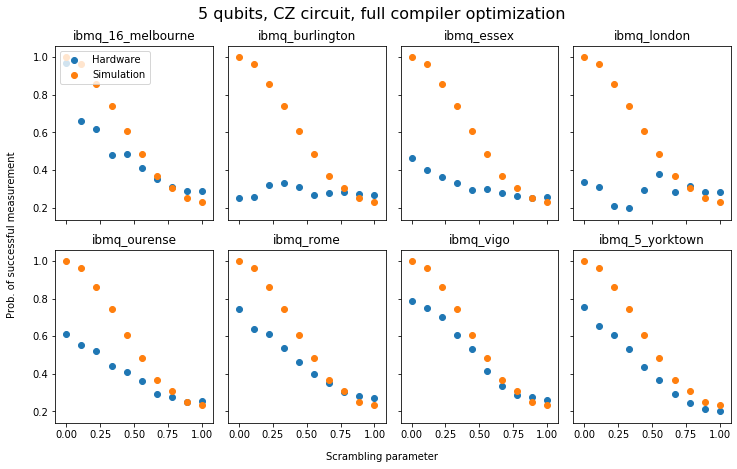

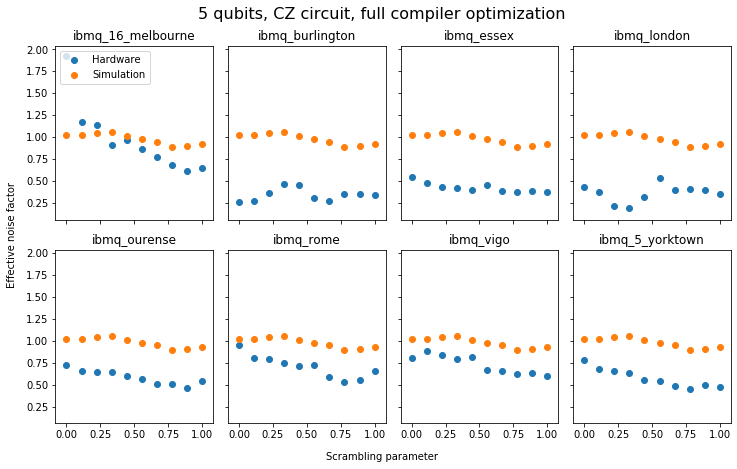

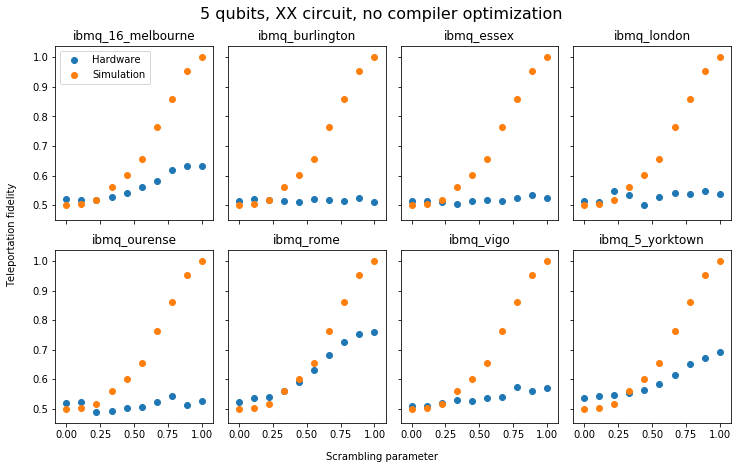

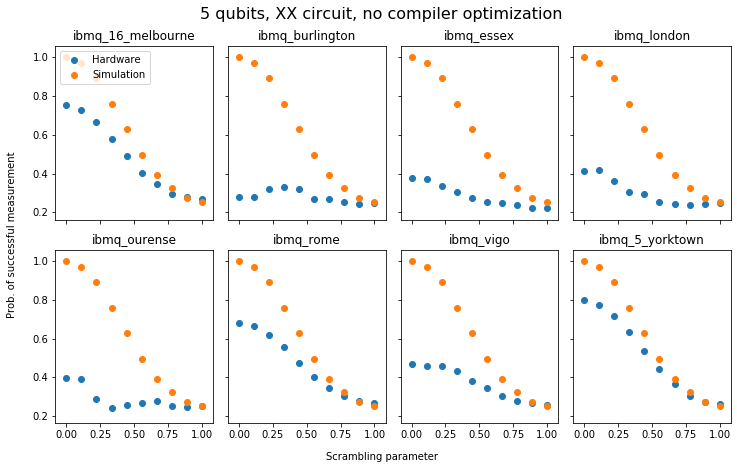

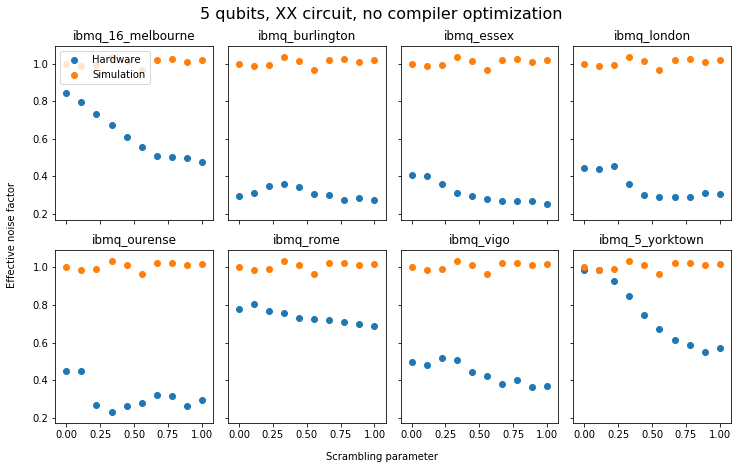

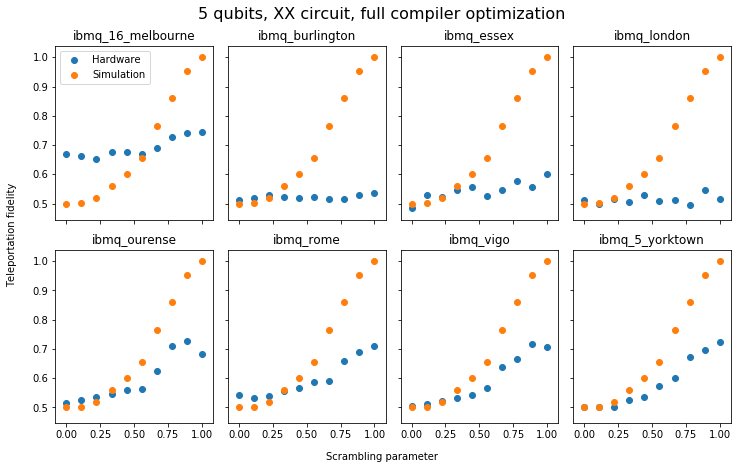

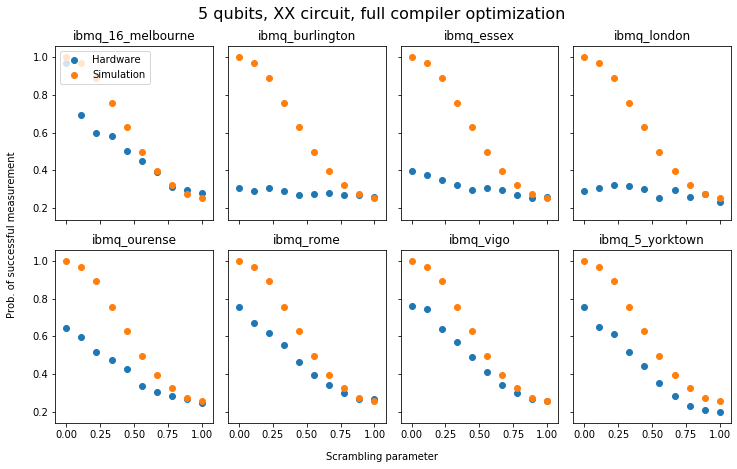

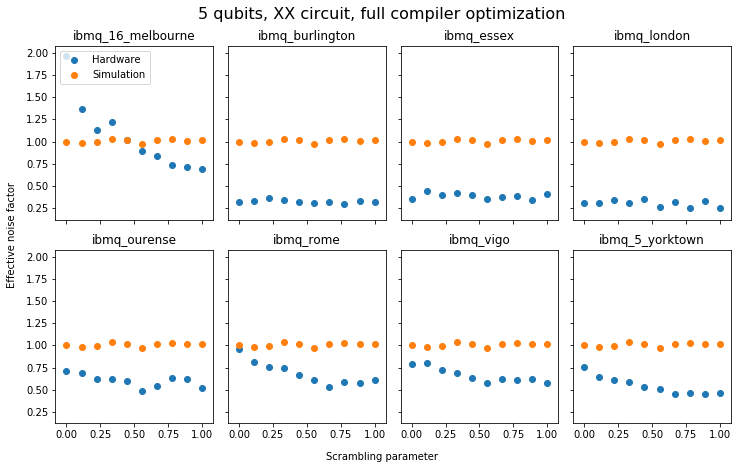

In [279]:
for i in range(2):
    for j in range(2):
        for m in range(3):
            plot_5(i, j, ys_5, m)

Indeed, there is a lot of variance between devices. Out of the 5-qubit devices (all except `ibmq_16_melbourne`), it looks like `ibmq_5_yorktown` and `ibmq_rome` are the least noisy. Yorktown has a bowtie architecture while Rome has a linear architecture between qubits, unlike the T-shaped connectivity that all other of IBM's 5-qubit have. Across evices, the CZ results are also slightly more consistent thhan XX circuits. It also seems like optimizing circuit compilation ruins the results on Melbourne, so we'll avoid doing that when we scale up to more qubits. Let's try 7-15 qubits now!

In [195]:
ns = list(range(7, 15, 2))
outs_cz = []
for n in ns:
    outs = run(n, i_choices=[0], j_choices=[0])
    outs_cz.append(outs)

In [271]:
ys_cz = []
for i in range(len(ns)):
    n = ns[i]
    ys = process(n, outs_cz[i], i_choices=[0], j_choices=[0])
    ys_cz.append(ys)
ys_cz = np.array(ys_cz)

In [269]:
def plot_n(orig, ns, all_ys, m=0):
    o = int(orig)
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))
    names = ['Teleportation fidelity', 'Prob. of successful measurement', 'Effective noise factor']
    metrics = ['F', 'P', 'N']
    for i in range(len(ns)):
        x1 = i // 2
        x2 = i % 2
        cind = 2*(i+1) + o
        axs[x1, x2].scatter(alphas, all_ys[i][0][0][:, m], label='Hardware')
        axs[x1, x2].scatter(alphas, all_y[cind][:, m], label='Simulation')
        axs[x1, x2].set_title(str(ns[i]) + ' qubits')
        if i == 0:
            axs[x1, x2].legend(loc='upper left')
    txt1 = fig.text(0.5, -0.02, 'Scrambling parameter', ha='center')
    txt2 = fig.text(-0.02, 0.5, names[m], va='center', rotation='vertical')
    label = 'CZ'
    if orig:
        label = 'XX'
    main = label + ' circuit, no compiler optimization, ibmq_16_melbourne'
    txt3 = fig.text(0.5, 1.0, main, ha='center', fontsize=16)
    plt.tight_layout()
    plt.savefig('out/16q_' + label + '_' + metrics[m] + '.pdf', bbox_extra_artists=(txt1, txt2, txt3), bbox_inches='tight')

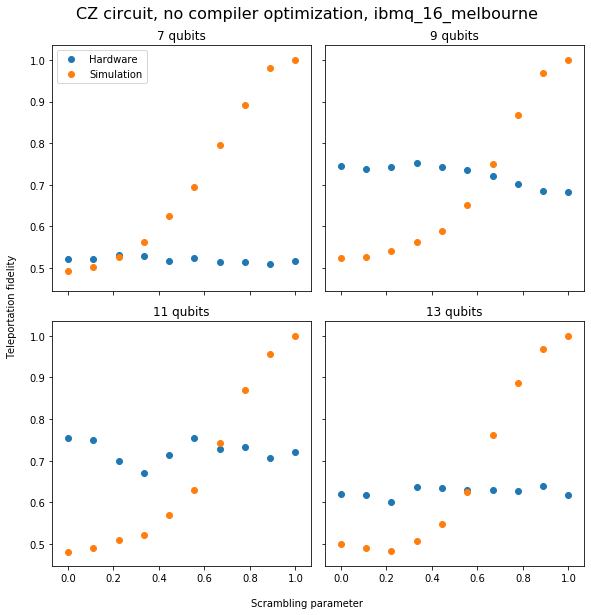

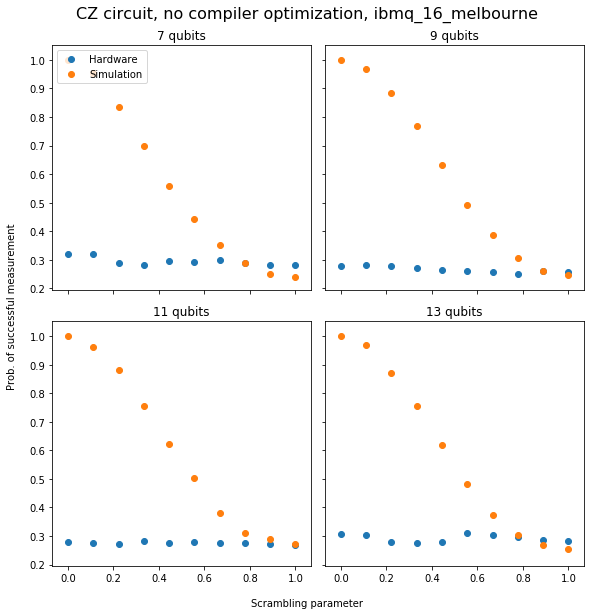

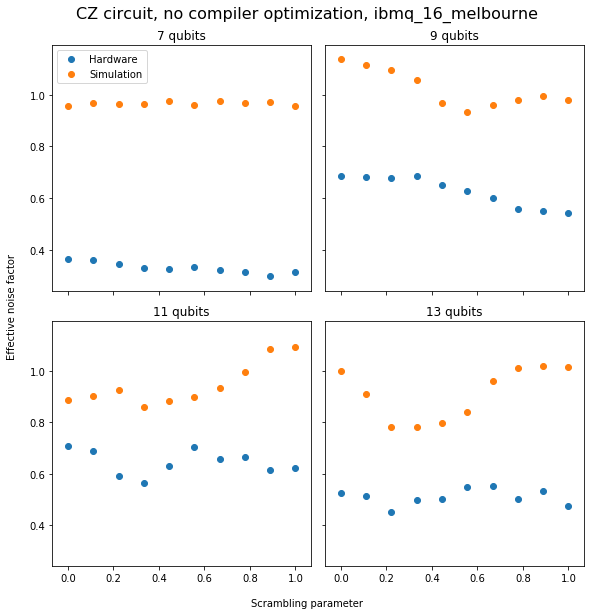

In [277]:
for m in range(3):
    plot_n(0, ns, ys_cz, m)

Well clearly that didn't work…. It looks like a lot of noise. This could be because the circuits are actually very large at this point for a NISQ device. To show what I mean, let's print out one of the transpiled 7-qubit circuits:

In [212]:
from qiskit.compiler import transpile
qbackend = provider.get_backend('ibmq_16_melbourne')
coupling_map = qbackend.configuration().coupling_map

This is the original CZ circuit, depth=15:

In [214]:
print('CZ raw circuit, depth=' + str(all_circuits[2][5].depth()))
print(all_circuits[2][5])

CZ raw circuit, depth=15
           ┌───┐┌───┐ ┌───┐ ┌───┐                   ┌───────┐               »
q788_0: |0>┤ X ├┤ Y ├─┤ H ├─┤ S ├──■───────────■────┤ Rx(0) ├─■────────■────»
           ├───┤└───┘ └───┘ └───┘  │           │    ├───────┤ │        │    »
q788_1: |0>┤ H ├──■────────────────■────■──────┼────┤ Rx(0) ├─■──■─────┼────»
           ├───┤  │                     │      │    ├───────┤    │     │    »
q788_2: |0>┤ H ├──┼─────■───────────────■──────■────┤ Rx(0) ├────■─────■────»
           └───┘  │   ┌─┴─┐                ┌───────┐└───────┘      ┌───────┐»
q788_3: |0>───────┼───┤ X ├───■─────────■──┤ Rx(0) ├────■────────■─┤ Rx(0) ├»
                ┌─┴─┐ └───┘   │         │  ├───────┤    │        │ ├───────┤»
q788_4: |0>─────┤ X ├─────────■────■────┼──┤ Rx(0) ├────■─────■──┼─┤ Rx(0) ├»
           ┌───┐└───┘              │    │  ├───────┤          │  │ ├───────┤»
q788_5: |0>┤ H ├──■────────────────■────■──┤ Rx(0) ├──────────■──■─┤ Rx(0) ├»
           └───┘┌─┴─┐┌─────┐┌───┐┌───┐┌

Now here's how it looks when we prepare the 7-qubit circuit for the Melbourne machine, i.e. this is what actually runs on the device. Depending on the transpiler seed, it has depth >50, which is already very deep! I commented out printing the full circuit since it's very large.

In [220]:
qc2 = transpile(all_circuits[2][5], basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=coupling_map, optimization_level=0)
print('CZ transpiled circuit, depth=' + str(qc2.depth()))
# print(qc2)

CZ transpiled circuit, depth=56


It gets even worse if we use the XX gates instead of the CZ gates. The original circuit depth remains at 15, but the transpiled circuit is significantly deeper than the CZ circuit. (It's also harder to optimize for the Qiskit compiler.)

In [221]:
print('XX raw circuit, depth=' + str(all_circuits[3][5].depth()))
print(all_circuits[3][5])
qc2 = transpile(all_circuits[3][5], basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=coupling_map, optimization_level=0)
print('XX transpiled circuit, depth=' + str(qc2.depth()))
# print(qc2)

XX raw circuit, depth=15
           ┌───┐┌───┐ ┌───┐      ┌───┐      ┌────────────┐               »
q848_0: |0>┤ X ├┤ Y ├─┤ H ├──────┤ S ├──────┤0           ├───────────────»
           ├───┤└───┘ └───┘      └───┘      │  Rxx(pi/2) │ ┌────────────┐»
q848_1: |0>┤ H ├──■─────────────────────────┤1           ├─┤0           ├»
           ├───┤  │                         └────────────┘ │  Rxx(pi/2) │»
q848_2: |0>┤ H ├──┼─────■──────────────────────────────────┤1           ├»
           └───┘  │   ┌─┴─┐ ┌─────────────┐               ┌┴────────────┤»
q848_3: |0>───────┼───┤ X ├─┤0            ├───────────────┤1            ├»
                ┌─┴─┐ └───┘ │  Rxx(-pi/2) │┌─────────────┐│             │»
q848_4: |0>─────┤ X ├───────┤1            ├┤0            ├┤  Rxx(-pi/2) ├»
           ┌───┐└───┘       └─────────────┘│  Rxx(-pi/2) ││             │»
q848_5: |0>┤ H ├──■────────────────────────┤1            ├┤0            ├»
           └───┘┌─┴─┐┌─────┐     ┌───┐     └────┬───┬────┘└────┬───┬────┘»


So maybe let's try optimizing the circuit, even though we saw it didn't work in the 5 qubit case. It could be the case that the large depth of the circuit creates more noise than variations in the compilation.

In [266]:
ns = list(range(7, 15, 2))
outs_cz_opt_o3 = []
for n in ns:
    outs = run(n, i_choices=[0], j_choices=[1])
    outs_cz_opt_o3.append(outs)

In [274]:
ys_cz_opt_o3 = []
for i in range(len(ns)):
    n = ns[i]
    ys = process(n, outs_cz_opt_o3[i], i_choices=[0], j_choices=[1])
    ys_cz_opt_o3.append(ys)
ys_cz_opt_o3 = np.array(ys_cz_opt_o3)

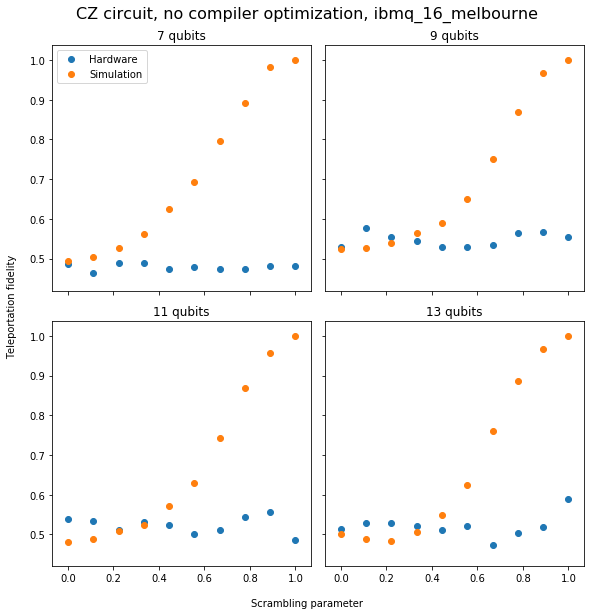

In [273]:
plot_n(0, ns, ys_cz_opt_o3, 0)

Hm. That didn't work. Maybe try less optimization? Sometimes with `optimization_level=3`, Qiskit creates an approximate circuit that doesn't precisely compile to the correct unitary.

In [227]:
ns = list(range(7, 15, 2))
outs_cz_opt = []
for n in ns:
    outs = run(n, i_choices=[0], j_choices=[1.0/3.0])
    outs_cz_opt.append(outs)

In [264]:
ys_cz_opt = []
for i in range(len(ns)):
    n = ns[i]
    ys = process(n, outs_cz_opt[i], i_choices=[0], j_choices=[1])
    ys_cz_opt.append(ys)
ys_cz_opt = np.array(ys_cz_opt)

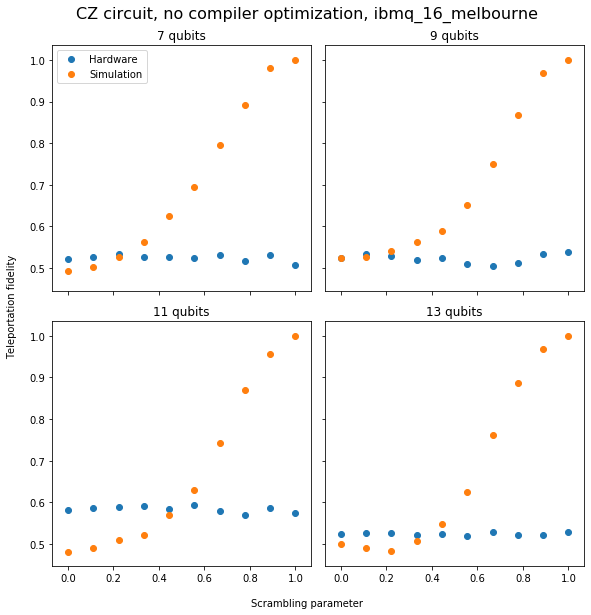

In [275]:
plot_n(0, ns, ys_cz_opt)

Last attempt is going back to the XX circuits.

In [202]:
outs_xx = []
for n in ns:
    outs = run(n, i_choices=[1], j_choices=[0])
    outs_xx.append(outs)

In [262]:
ys_xx = []
for i in range(len(ns)):
    n = ns[i]
    ys = process(n, outs_xx[i], i_choices=[1], j_choices=[0])
    ys_xx.append(ys)
ys_xx = np.array(ys_xx)

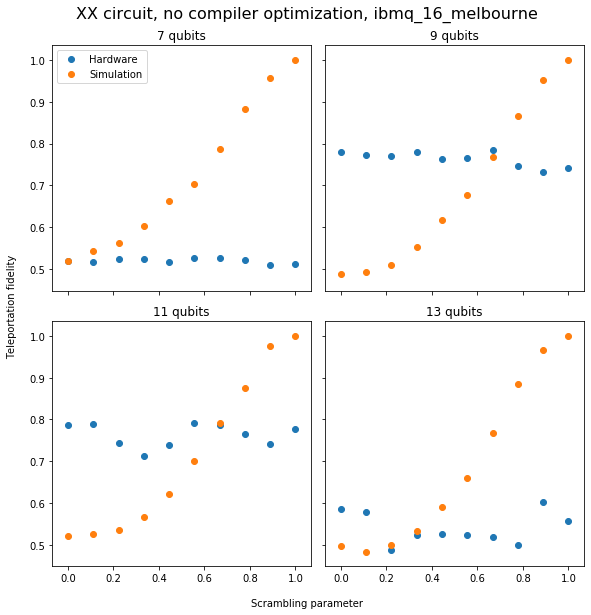

In [276]:
plot_n(1, ns, ys_xx)